# Preprocessing of question-answering pairs

## Description
The the scores distributions in different filtering ways, output json file at the end.

## Tasks

1. Check answers count for each question

2. Filter answers with blocks of code

3. Check answers count for each question again

4. Score distributions and filter questions with less than 3 answers

5. Score distribution

6. JSON output

In [25]:
import pandas as pd
from bs4 import BeautifulSoup
from os.path import join as opj
import plotly.figure_factory as ff
import numpy as np
from sklearn import preprocessing
import seaborn as sns

In [26]:
pd.set_option("display.max_colwidth", None)

In [27]:
data_path = r'D:\CQA_RLHF\data\interim'

In [28]:
q_a_df = pd.read_csv(opj(data_path, 'question_answers.csv'))

In [29]:
q_a_df['A_Score_div_views'] = q_a_df.A_Score / q_a_df.ViewCount
q_a_df['A_Score_div_n_ans'] = q_a_df.A_Score / q_a_df.AnswerCount

## Count of the answers for each questions before filtering

In [5]:
print(
    f'{round(sum(q_a_df["Q_Id"].value_counts() == 1) / len(q_a_df.Q_Id.unique()) * 100, 2)}% of questions have only one answer.'
)

68.68% of questions have only one answer.


Статистики Score'ов для ответов без кода

In [49]:
print(q_a_df[['A_Score', 'A_Score_div_views', 'A_Score_div_n_ans']].describe())

             A_Score  A_Score_div_views  A_Score_div_n_ans
count  180737.000000      180737.000000      180737.000000
mean        4.487786           0.004122           1.259866
std        31.380434           0.011240           4.799685
min       -42.000000          -0.095238         -10.000000
25%         0.000000           0.000000           0.000000
50%         1.000000           0.000210           0.333333
75%         2.000000           0.002457           1.000000
max      4870.000000           0.250000         589.000000


## Answers without blocks of code

In [30]:
def filter_column(df, column_name, text_to_filter, regex=False):
    before_filtering = len(df)
    df = df[
        ~df[f"{column_name}"].str.contains(f"{text_to_filter}", na=False, regex=regex)
    ]
    after_filtering = len(df)
    print(f"Deleted {before_filtering-after_filtering} rows")
    return df

In [31]:
q_a_df_no_code = filter_column(q_a_df, 'A_Body', "</code></pre>")

Deleted 114884 rows


In [8]:
print(
    f'{round(sum(q_a_df_no_code["Q_Id"].value_counts() == 1) / len(q_a_df_no_code.Q_Id.unique()) * 100, 2)}% of questions have only one answer, answers without blocks of code.'
)

82.17% of questions have only one answer, answers without blocks of code.


Статистики Score'ов для ответов без кода

In [53]:
print(q_a_df_no_code[['A_Score', 'A_Score_div_views', 'A_Score_div_n_ans']].describe())

            A_Score  A_Score_div_views  A_Score_div_n_ans
count  65853.000000       65853.000000       65853.000000
mean       2.657935           0.003111           0.939361
std       14.927702           0.008936           3.207656
min      -42.000000          -0.095238         -10.000000
25%        0.000000           0.000000           0.000000
50%        1.000000           0.000111           0.250000
75%        2.000000           0.002110           1.000000
max     1147.000000           0.200000         163.857143


Распределение кол-ва ответов без кода на вопросы

<AxesSubplot:>

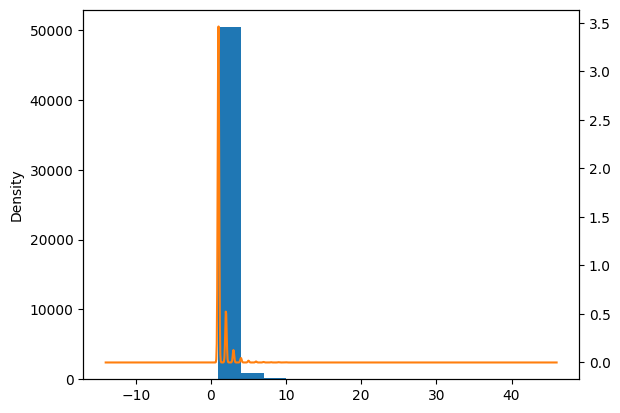

In [32]:
ax = q_a_df_no_code.Q_Id.value_counts().hist(bins=10)
q_a_df_no_code.Q_Id.value_counts().plot(kind='kde', ax=ax, secondary_y=True)

### Count of answers to each question

Match for each questions in a row count of anaswers

In [33]:
q_a_df_no_code['count_available_anaswers'] = q_a_df_no_code['Q_Id'].map(q_a_df_no_code['Q_Id'].value_counts())

In [38]:
print('1 answer available:', len(q_a_df_no_code.loc[q_a_df_no_code['count_available_anaswers'] == 1]))
print('More than 1 answer available:', len(q_a_df_no_code.loc[q_a_df_no_code['count_available_anaswers'] != 1]))

1 answer available: 42316
More than 1 answer available: 23537


### Scale answer score for training regression problem

#### Ideas

1. Filter outliers, MinMax(MaxAbs) scale for filtered data, add outliers with score 1(-1), accepted answers scores equal to 1

2. Scale separatly positives and negatives scores (MaxAbs/MinMax)

In [57]:
print(q_a_df_no_code[['A_Score', 'A_Score_div_views', 'A_Score_div_n_ans']].describe())

            A_Score  A_Score_div_views  A_Score_div_n_ans
count  65853.000000       65853.000000       65853.000000
mean       2.657935           0.003111           0.939361
std       14.927702           0.008936           3.207656
min      -42.000000          -0.095238         -10.000000
25%        0.000000           0.000000           0.000000
50%        1.000000           0.000111           0.250000
75%        2.000000           0.002110           1.000000
max     1147.000000           0.200000         163.857143


In [39]:
m_m_scaler = preprocessing.MinMaxScaler()
m_a_scaler = preprocessing.MaxAbsScaler()

##### Transform without outliers

Фильтрация выбросов

In [22]:
def filter_outliers_iqr(data, column):
    q1, q3 = data[column].quantile([0.15, 0.75])
    iqr = q3 - q1
    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)
    return (
        data[column][(data[column] > lower_bound) & (data[column] < upper_bound)],
        data[column][data[column] <= lower_bound],
        data[column][data[column] >= upper_bound],
    )


def filter_and_transform(data, column, scaler, new_col_name):
    filtered_data, lower_outliers, upper_outliers = filter_outliers_iqr(data, column)

    filtered_scaled_data = scaler.fit_transform(filtered_data.values.reshape(-1, 1)).reshape(1, -1)[0]
    filtered_scaled_data = pd.Series(filtered_scaled_data, index=filtered_data.index)
    lower_outliers = lower_outliers.replace(to_replace=lower_outliers.values, value=-1)
    upper_outliers = upper_outliers.replace(to_replace=upper_outliers.values, value=1)

    transformed_series = pd.concat(
        [filtered_scaled_data, lower_outliers, upper_outliers], axis=0
    )
    transformed_series.name = new_col_name

    return data.join(transformed_series, how="left", on=data.index)

In [23]:
q_a_df_no_code = filter_and_transform(q_a_df_no_code, 'A_Score_div_n_ans', m_a_scaler, 'A_Score_div_n_ans_max_abs')
q_a_df_no_code = filter_and_transform(q_a_df_no_code, 'A_Score_div_n_ans', m_m_scaler, 'A_Score_div_n_ans_min_max')

q_a_df_no_code = filter_and_transform(q_a_df_no_code, 'A_Score_div_views', m_a_scaler, 'A_Score_div_views_max_abs')
q_a_df_no_code = filter_and_transform(q_a_df_no_code, 'A_Score_div_views', m_m_scaler, 'A_Score_div_views_min_max')

Изменить Score Accepted Asnwers to 1

In [11]:
accepted_answers_indexes = q_a_df_no_code[
    q_a_df_no_code["A_Id"].isin(q_a_df_no_code["AcceptedAnswerId"].unique())
].index

In [ ]:
q_a_df_no_code.loc[
    accepted_answers_indexes, ["A_Score_div_n_ans_max_abs", "A_Score_div_views_max_abs"]
] = 1

Просмотр KDE

<AxesSubplot:ylabel='Density'>

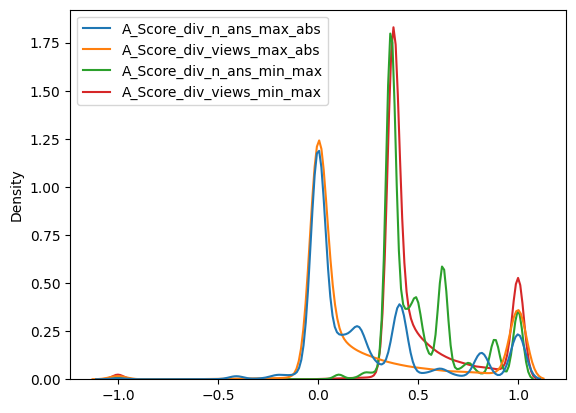

In [24]:
sns.kdeplot(
    data=[
        q_a_df_no_code["A_Score_div_n_ans_max_abs"],
        q_a_df_no_code["A_Score_div_views_max_abs"],
        q_a_df_no_code["A_Score_div_n_ans_min_max"],
        q_a_df_no_code["A_Score_div_views_min_max"],
    ],
)

##### Separate transformations

In [61]:
def filter_neg_pos_transform(data, column, new_col_name, filter=True):
    if filter:
        filtered_data, lower_outliers, upper_outliers = filter_outliers_iqr(data, column)
        lower_outliers = lower_outliers.replace(to_replace=lower_outliers.values, value=-1)
        upper_outliers = upper_outliers.replace(to_replace=upper_outliers.values, value=1)

    else:
        filtered_data = data[column]


    negative_scaled_data = filtered_data[filtered_data < 0].transform(lambda x: x / np.abs(x.min()))
    positive_scaled_data = filtered_data[filtered_data >= 0].transform(lambda x: x / np.abs(x.max()))

    if filter:
        transformed_series = pd.concat(
        [positive_scaled_data, negative_scaled_data, lower_outliers, upper_outliers], axis=0
    )
    else:
        transformed_series = pd.concat([positive_scaled_data, negative_scaled_data], axis=0)

    transformed_series.name = new_col_name

    return data.join(transformed_series, how="left", on=data.index)

In [62]:
q_a_df_no_code = filter_neg_pos_transform(q_a_df_no_code, 'A_Score_div_n_ans', 'A_Score_div_n_ans_sep')

q_a_df_no_code = filter_neg_pos_transform(q_a_df_no_code, 'A_Score_div_views', 'A_Score_div_views_sep')

In [23]:
accepted_answers_indexes = q_a_df_no_code[
    q_a_df_no_code["A_Id"].isin(q_a_df_no_code["AcceptedAnswerId"].unique())
].index

q_a_df_no_code.loc[
    accepted_answers_indexes, ["A_Score_div_views_sep", "A_Score_div_n_ans_sep"]
] = 1

<AxesSubplot:ylabel='Density'>

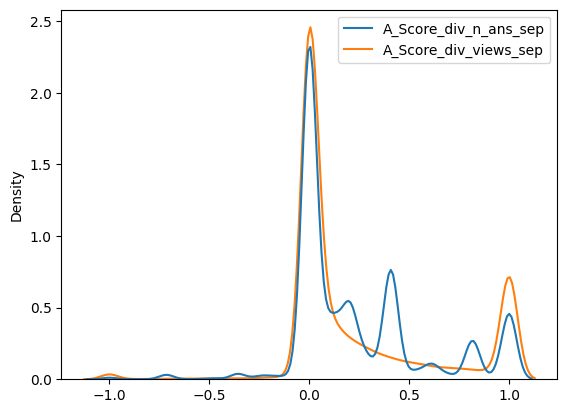

In [63]:
sns.kdeplot(
    data=[
        # q_a_df_no_code["A_Score_div_n_ans_max_abs"],
        # q_a_df_no_code["A_Score_div_views_max_abs"],
        # q_a_df_no_code["A_Score_div_n_ans_min_max"],
        # q_a_df_no_code["A_Score_div_views_min_max"],
        q_a_df_no_code["A_Score_div_n_ans_sep"],
        q_a_df_no_code["A_Score_div_views_sep"],
    ],
)

## Use $log_2$ for scores

In [23]:
import math

In [35]:
accepted_answers_indexes = q_a_df_no_code[
    q_a_df_no_code["A_Id"].isin(q_a_df_no_code["AcceptedAnswerId"].unique())
].index

In [53]:
math.log2(1)

0.0

## Saving data as JSON

In [75]:
log_scores = []
for i in q_a_df_no_code['A_Score']:
    if i >= 0:
        log_scores.append(round(np.log(i+1)))
    else:
        log_scores.append(-1)

In [76]:
len(log_scores)

65853

In [78]:
q_a_df_no_code['Log_scores'] = log_scores

In [84]:
q_a_df_no_code['Log_scores'] = q_a_df_no_code['Log_scores'] + q_a_df_no_code['AcceptedAnswer']

In [85]:
import json
import re

In [86]:
save_path = r'D:\CQA_RLHF\data\processed\log_score'

In [50]:
q_a_df_no_code['AcceptedAnswer'] = q_a_df_no_code['AcceptedAnswerId'] == q_a_df_no_code['A_Id']

In [88]:
# data = q_a_df_no_code[['Q_CreationDate', 'Q_Title', 'Q_Body', 'A_Body', 'A_Score_div_n_ans_sep', 'AcceptedAnswer', 'count_available_anaswers']]
data = q_a_df_no_code[['Q_CreationDate', 'Q_Title', 'Q_Body', 'A_Body', 'Log_scores', 'AcceptedAnswer', 'count_available_anaswers']]

In [89]:
data['Q_Title'] = data['Q_Title'].apply(lambda x: BeautifulSoup(x, 'html.parser').get_text().strip())
data['Q_Body'] = data['Q_Body'].apply(lambda x: BeautifulSoup(x, 'html.parser').get_text().strip())
data['A_Body'] = data['A_Body'].apply(lambda x: BeautifulSoup(x, 'html.parser').get_text().strip())

c:\ProgramData\Anaconda3\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


In [94]:
data = data.rename(
    columns={
        "Q_Title": "Title",
        "Q_Body": "Question",
        "A_Body": "Answer",
        "Log_scores": "Score",
        "AcceptedAnswer": "Is_accepted",
        "count_available_anaswers": "N_answers",
    }
)

In [97]:
data = data.sort_values('Q_CreationDate', ascending=True)

In [98]:
data.to_csv(r'D:\CQA_RLHF\data\processed\log_score\1.0-all-data-log_score.csv', index=False)

In [99]:
from sklearn.model_selection import train_test_split

In [33]:
train_df = data[:-3000]
val_df = data[-3000:-2000]
test_df = data[-2000:]
# Convert each set to a dictionary
train_dict = train_df.to_dict(orient='records')
val_dict = val_df.to_dict(orient='records')
test_dict = test_df.to_dict(orient='records')

# Combine the dictionaries into a list of dictionaries
data_to_save = {'train': train_dict, 'val': val_dict, 'test': test_dict}

# Save the list of dictionaries to a JSON file
with open(opj(save_path, '1.0-data-div-ans-sep.json'), 'w') as f:
    json.dump(data_to_save, f)


In [68]:
with open(opj(save_path, '1.0-data-div-ans-sep.json'), 'r') as f:
    pairs = json.load(f)